<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import math
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [31]:

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving temple.jpg to temple.jpg

Upload Style Image


Saving fauvism.jpg to fauvism (4).jpg
Content Path: <_io.BytesIO object at 0x7fc697111938>
Style Path: <_io.BytesIO object at 0x7fc697111b48>


In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**
* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()#.cuda()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval().cuda()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [34]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

contentLayers = [19]
styleLayers = [0, 5, 10, 17, 24]

def filterStyleAndContentImages(layerOutputs):
  # Choose the layers to use for style and content transfer
  contentOutputs = dict(filter(lambda element: element[0] in contentLayers, layerOutputs.items()))
  styleOutputs = dict(filter(lambda element: element[0] in styleLayers, layerOutputs.items()))

  return contentOutputs, styleOutputs

requested = [*contentLayers, *styleLayers]
# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
model = VGGIntermediate(requested)
# Cache the outputs of the content and style layers for their respective images
layerOutputs = model(content_image)
contentOutputs, _ = filterStyleAndContentImages(layerOutputs)

layerOutputs = model(style_image)
_, styleOutputs = filterStyleAndContentImages(layerOutputs)

del _

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**

**DONE:**
* Display the style tensor and content tensor transformed back to an image


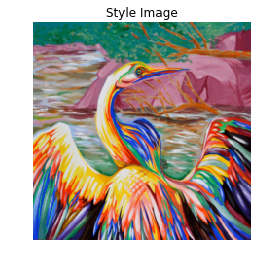

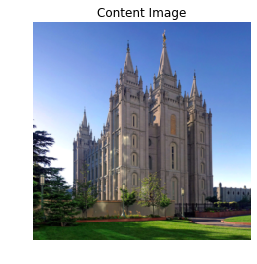

In [35]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

___

### Part 3
Create a classes for the style and content loss

**TODO:**

**DONE:**
* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class


In [0]:
def gramMatrix(input):

  #batch size will always be 1?
  batchSize, featureMapCount, imageHeight, imageWidth = input.size()

  featureVectors = input.view(batchSize * featureMapCount, imageHeight * imageWidth)

  orthoBasis = torch.mm(featureVectors, featureVectors.t())

  return orthoBasis.div(batchSize * featureMapCount * imageHeight * imageWidth)
  
class ContentLoss(nn.Module):
  def __init__(self, comparisonImage):
    super(ContentLoss, self).__init__()
    self.comparisonImage = comparisonImage.detach()

  def forward(self, inputImage):
    return torch.div(F.mse_loss(inputImage, self.comparisonImage, reduction='sum'), 2)

    
class StyleLoss(nn.Module):
  def __init__(self, styleFeature):
    super(StyleLoss, self).__init__()

    self.styleFeatures = gramMatrix(styleFeature.detach())

  def forward(self, inputImage):
    transformedInputImage = gramMatrix(inputImage)

    height, width = transformedInputImage.size()

    #each of these modules only has one feature map, so N = 1
    divisor = 4 * math.pow(height * width, 2)

    return torch.div(F.mse_loss(transformedInputImage, self.styleFeatures, reduction='sum'), divisor)

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
contentLossModules = dict([(layerKey, ContentLoss(contentOutputs[layerKey])) for layerKey in contentOutputs])
# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
styleLossModules = dict([(layerKey, StyleLoss(styleOutputs[layerKey])) for layerKey in styleOutputs])

#print(contentLossModules.keys(), styleLossModules.keys())

___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

**DONE:**
* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!



epoch 0:
style loss: 0.000001, content loss: 0.000000

epoch 50:
style loss: 0.000015, content loss: 767355.062500

epoch 100:
style loss: 0.000010, content loss: 439169.718750

epoch 150:
style loss: 0.000008, content loss: 283859.062500

epoch 200:
style loss: 0.000007, content loss: 227288.187500

epoch 250:
style loss: 0.000006, content loss: 216173.734375

epoch 300:
style loss: 0.000006, content loss: 206166.000000

epoch 350:
style loss: 0.000006, content loss: 182507.875000

epoch 400:
style loss: 0.000006, content loss: 234516.875000

epoch 450:
style loss: 0.000009, content loss: 312361.968750



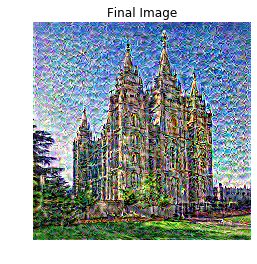

In [51]:
# Start with a copy of the content image
inputImage = content_image.clone().requires_grad_(True)
# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
optimizer = optim.Adam([inputImage], lr=.055) #lr=.1 <--- Dr. Wingate said in slack that we can modify the learning rate, so I'm going to leave this as the default value...

totalEpochs = 500

styleWeight = 1#/5#10000
epochs = 0

while epochs < totalEpochs:

  inputImage.data.clamp_(0, 1)

  optimizer.zero_grad()

  layerOutputs = model(inputImage)
  contentOutputs, styleOutputs = filterStyleAndContentImages(layerOutputs)

  styleLoss = 0
  contentLoss = 0

  for layerKey in contentLossModules:
    contentLoss += contentLossModules[layerKey](contentOutputs[layerKey])

  for layerKey in styleLossModules:
    styleLoss += styleLossModules[layerKey](styleOutputs[layerKey])

  loss = contentLoss + (styleLoss * styleWeight)

  loss.backward()

  if epochs % 50 == 0:
    print("epoch {}:".format(epochs))
    print("style loss: {:4f}, content loss: {:4f}\n".format(styleLoss.item(), contentLoss.item()))
  
  optimizer.step()#contentLoss + styleLoss

  epochs += 1

inputImage.data.clamp_(0, 1)

# Show the image
display(inputImage, title="Final Image")

### Part 5

**TODO:**

**DONE:**
- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**Equation 1:**

* p is the matrix representation of the original content image
* x is the matrix representation of the image that is being generated
* l is a particular layer in the VGG network
* F is the output of a layer for the generated image
* P is the output of a layer for the original image

The function says that the loss in content for a particular layer can be calculated by capturing the output of that layer when feeding it the original image and generated image, subtracting the value of each entry in the original image output matrix from the value in the same location in the generated image output matrix, squaring each of the results, adding them all together, then dividing by 2


**Equation 3:**

* l is a layer in the network
* G represents the correlation between different channels output from a layer in the network.
* i and j are different channels output from a particular layer, reshaped into vectors
* k represents an index into a vector
* F represents the value in a channel (that has been turned into a vector) at a particular location

The equation says that the correlation between the output of two channels can be found by turning the two channels into vectors, then multiplying each element in one vector by the element in the same location in the other vector, then summing all of the entries together.

**Equation 4:**

* l is a layer in the network
* E represents the unweighted style error in a layer
* N is the number of channels output in a layer
* M is the number of elements in a channel (height * width)
* i is a row in a matrix
* j is a column in a matrix
* G is the style representation of the generated image in a layer
* A is the style representation of the original image in a layer

The equation says that the style error for a layer can be found by subtracting each element in the style representation of the original image from the style representation of the generated image in the same location, squaring each result, adding them all together, and then dividing by (4 * the number of channels output in the layer * the number of channels output in the layer * the number of elements in a channel * the number of elements in a channel)

**Equation 5:**

* Lstyle is the total style loss between two images
* a is the matrix representing the original image
* x is the matrix representing the image being generated
* l is a layer in the network
* L is the total number of layers in the network
* w is the weight of a layer's loss
* E is the unweighted loss of a layer

The equation says that the total style loss between the original image and the image being generated can be found by multiplying each layer's unweighted style loss by its corresponding weight, then adding all of the weighted errors together.
